In [30]:
from scipy.integrate import solve_ivp
import torch
from torch import nn
import torch.optim as optim
import torch.nn as nn
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

from timeit import default_timer as tdt
import torch.nn.init as init

from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt

if torch.cuda.is_available():
    my_device = 'cuda' # I think I may have broken the cuda version
else:
    my_device = 'cpu'
    


In [31]:
# Time setup
n_days = 1000
t_num = torch.linspace(0, n_days, 1001)

## Disease setup
alpha_SIR = 0.005
beta_SIR = 0.015

# Initial conditions
N = 1.0    # Population size
I0_num = 0.05
R0_num = 0.0
S0_num = 1 - I0_num - R0_num    # Initial number of susceptible

In [32]:
# Solve numerically
def SIR_model_num(t, y, beta_SIR, alpha_SIR):
    S, I, R = y
    dSdt = -beta_SIR * S * I
    dIdt = beta_SIR * S * I - alpha_SIR * I
    dRdt = alpha_SIR * I
    return [dSdt, dIdt, dRdt]

# Setup initial conditions 
y0 = [S0_num, I0_num, R0_num]

# Solve using LSODA method from scipy
sol = solve_ivp(SIR_model_num, [t_num[0], t_num[-1]], y0, args=(beta_SIR, alpha_SIR), t_eval=t_num, method='LSODA')

S_data = torch.tensor(sol.y[0])
I_data = torch.tensor(sol.y[1])
R_data = torch.tensor(sol.y[2])
print(sol.message)

The solver successfully reached the end of the integration interval.


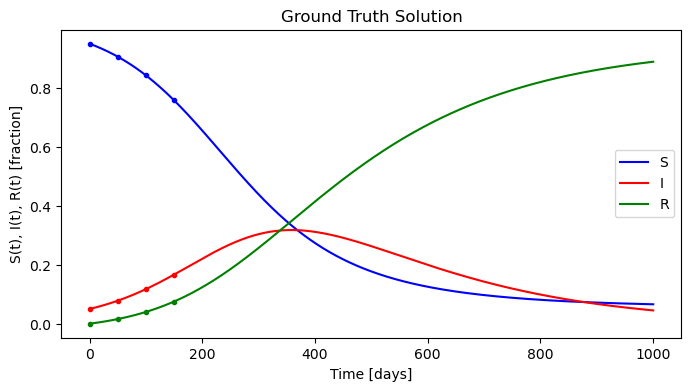

In [33]:
# Plot numerical solution
def plot_solution(t, S, I, R, title=''):
    t = t.clone().detach()
    S = S.clone().detach()
    I = I.clone().detach()
    R = R.clone().detach()
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.plot(t, S, label='S', color='blue')
    ax.plot(t, I, label='I', color='red')
    ax.plot(t, R, label='R', color='green')

    ax.set_xlabel('Time [days]')
    ax.set_ylabel('S(t), I(t), R(t) [fraction]')
    ax.legend()
    ax.set_title(title)
    
    return fig, ax
    
fig, ax = plot_solution(t_num, S_data, I_data, R_data, 'Ground Truth Solution')

# Picking some points
t_data_points = t_num[0:151:50]
S_data_points = S_data[0:151:50]
I_data_points = I_data[0:151:50]
R_data_points = R_data[0:151:50]
ax.plot(t_data_points, S_data_points, linestyle='', marker='.', color='blue')
ax.plot(t_data_points, I_data_points, linestyle='', marker='.', color='red')
ax.plot(t_data_points, R_data_points, linestyle='', marker='.', color='green')

In [34]:
def monitor_plot():
    # Setup monitor plot that runs concurrently with training loop to illustrate: loss, adaptive weights, the network vs ground truth result
    # and in the bottom right the rhs of each equation and the derivative. These should of course be similar in a perfect world.
    fig, ax = plt.subplots(2, 2, figsize=(12,8))
    # Plot losses
    line_loss_total, = ax[0,0].plot([0.5,1], [0.5,1], color='k', label='Total Loss')
    line_loss_ode, = ax[0,0].plot([0.5,1], [0.5,1], color='red', label='ODE Loss', linestyle='--')
    line_loss_ic, = ax[0,0].plot([0.5,1], [0.5,1], color='blue', label='IC Loss', linestyle='--')
    line_loss_data, = ax[0,0].plot([0.5,1], [0.5,1], color='green', label='Data Loss', linestyle='--')
    ax[0,0].legend()
    ax[0,0].set_xlabel('Epochs')
    ax[0,0].set_ylabel('Loss')
    ax[0,0].set_yscale('log')

    # Plot ground truth next to solution from network
    ax[0,1].plot(t_num.detach(), S_data.detach(), color='blue', alpha=0.5, marker='', linestyle='-', label='S_truth')
    ax[0,1].plot(t_num.detach(), I_data.detach(), color='red', alpha=0.5, marker='', linestyle='-', label='I_truth')
    ax[0,1].plot(t_num.detach(), R_data.detach(), color='green', alpha=0.5, marker='', linestyle='-', label='R_truth')
    line_S, = ax[0,1].plot([0.5,1], [0.5,1], color='lightblue', linestyle='', label='S_net', marker='.')
    line_I, = ax[0,1].plot([0.5,1], [0.5,1], color='coral', linestyle='', label='I_net', marker='.')
    line_R, = ax[0,1].plot([0.5,1], [0.5,1], color='lightgreen', linestyle='', label='R_net', marker='.')
    ax[0,1].legend()
    ax[0,1].set_xlabel('Time [days]')
    ax[0,1].set_ylabel('S, I, R - (t)')

    # Adaptive weights plot
    line_aw0, = ax[1,0].plot([0.5,1], [0.5,1], color='red', linestyle='-', label='aw[0]')
    line_aw1, = ax[1,0].plot([0.5,1], [0.5,1], color='blue', linestyle='-', label='aw[1]')
    ax[1,0].set_ylabel('Adaptive Weights')
    ax[1,0].legend()
    
    # RHS and derivative plot
    line_dSdt, = ax[1,1].plot([0.5,1], [0.5,1], color='blue', linestyle='', label='dSdt', marker='.')
    line_dIdt, = ax[1,1].plot([0.5,1], [0.5,1], color='red', linestyle='', label='dIdt', marker='.')
    line_dRdt, = ax[1,1].plot([0.5,1], [0.5,1], color='green', linestyle='', label='dRdt', marker='.')

    line_RHS_S, = ax[1,1].plot([0.5,1], [0.5,1], color='lightblue', linestyle='', label='rhs_S', marker='.')
    line_RHS_I, = ax[1,1].plot([0.5,1], [0.5,1], color='coral', linestyle='', label='rhs_I', marker='.')
    line_RHS_R, = ax[1,1].plot([0.5,1], [0.5,1], color='lightgreen', linestyle='', label='rhs_R', marker='.')
    ax[1,1].set_title('RHS and derivative comparison')
    ax[1,1].set_xlim(0,1000)
    ax[1,1].set_ylim(0,1)
    ax[1,1].set_xlabel('Time [days]')
    ax[1,1].legend()
    
    plt.tight_layout()
    return fig, ax, line_loss_total, line_loss_ode, line_loss_ic, line_loss_data, line_S, line_I, line_R, line_RHS_S, line_RHS_I, line_RHS_R, line_dSdt, line_dIdt, line_dRdt, line_aw0, line_aw1

In [35]:
# Defining loss functions

def smooth_thresholding(loss, threshold, steepness):
    # Smooth thresholding for looseining the initial condition requirement
    shifted_loss = steepness * (loss - threshold)
    return torch.sigmoid(shifted_loss) - torch.sigmoid(-steepness * threshold)

torch_MSE_loss = torch.nn.MSELoss()

def get_loss_ode(t, net, beta_SIR, alpha_SIR):
    # Calculate net solution
    S, I, R = net(t)
    
    # Use autograd to get derivatives. Divide by 1000 since the network has normalized time between [0,1] where real time it [0,1000]
    dSdt = 1.0/1000.0*torch.autograd.grad(S, t, grad_outputs=torch.ones_like(S), create_graph=True)[0]
    dIdt = 1.0/1000.0*torch.autograd.grad(I, t, grad_outputs=torch.ones_like(I), create_graph=True)[0]
    dRdt = 1.0/1000.0*torch.autograd.grad(R, t, grad_outputs=torch.ones_like(R), create_graph=True)[0]

    # Calculate MSE loss
    rhs_S = -beta_SIR * S * I
    loss_S = torch_MSE_loss(dSdt, rhs_S)
    
    rhs_I = beta_SIR * S * I - alpha_SIR * I
    loss_I = torch_MSE_loss(dIdt, rhs_I)
    
    rhs_R = alpha_SIR * I
    loss_R = torch_MSE_loss(dRdt, rhs_R)
    
    # Sum the errors
    loss = loss_S + loss_I + loss_R
    
    return loss, S, I, R, dSdt, dIdt, dRdt, rhs_S, rhs_I, rhs_R

def get_loss_data(t, net, S_truth, I_truth, R_truth):
    
    # Reshaping
    t = t.view(-1,1) / 1000.0
    S_truth = S_truth.view(-1,1)
    I_truth = I_truth.view(-1,1)
    R_truth = R_truth.view(-1,1)
    
    # Calculate net solution
    S, I, R = net(t)
    
    # MSE loss between net result and truth
    loss_S = torch_MSE_loss(S, S_truth)
    loss_I = torch_MSE_loss(I, I_truth)
    loss_R = torch_MSE_loss(R, R_truth)
    
    # Sum loss
    loss = loss_S + loss_I + loss_R
    
    return loss

def get_loss_initial_condition(t, net, S_truth, I_truth, R_truth):
    # This is the same as the get_data loss but we can add thresholding to lower the sensitivity to the exact initial condition.
    # Reshaping
    t = t.view(-1,1) / 1000.0
    S_truth = S_truth.view(-1,1)
    I_truth = I_truth.view(-1,1)
    R_truth = R_truth.view(-1,1)
    
    # Calculate net solution
    S, I, R = net(t)
    
    # MSE loss between net result and truth
    diff_S = (S - S_truth).abs()
    loss_S = torch_MSE_loss(S, S_truth) * smooth_thresholding(diff_S, torch.tensor(0.1), torch.tensor(50.0)).squeeze()
    diff_I = (I - I_truth).abs()
    loss_I = torch_MSE_loss(I, I_truth) * smooth_thresholding(diff_I, torch.tensor(0.1), torch.tensor(50.0)).squeeze()
    diff_R = (R - R_truth).abs()
    loss_R = torch_MSE_loss(R, R_truth) * smooth_thresholding(diff_R, torch.tensor(0.1), torch.tensor(50.0)).squeeze()
    
    # Sum loss
    loss = loss_S + loss_I + loss_R
    
    return loss

def get_loss_for_not_correct_number_of_people(t, net):
    # Find network solution
    S, I, R = net(t)
    
    ## Adding loss for negative number of people
    loss = torch.tensor(0.0, dtype=torch.float64, device=my_device)
    out_of_bounds_saved = []
    for value in [S, I, R]:
        out_of_bounds = torch.where((value < 0.0) | (value > 1.0), value, torch.tensor(0.0, device=my_device, dtype=torch.float64))
        out_of_bounds_saved.append(out_of_bounds)
        loss += torch_MSE_loss(out_of_bounds, torch.zeros_like(out_of_bounds, device=my_device, dtype=torch.float64))
    
    return loss, out_of_bounds_saved

In [36]:
# ================== Defining the network(s) ==================
class FFN(nn.Module):
    def __init__(self, input_size, hidden_layers_size, output_size):
        super(FFN, self).__init__()
        
        n_layers = len(hidden_layers_size)
        HL = hidden_layers_size
        
        # Define layers
        self.L1 = nn.Linear(input_size, HL[0]).double()
        self.L2 = nn.Linear(HL[0], HL[1]).double()
        self.L3 = nn.Linear(HL[1], HL[2]).double()
        #self.L4 = nn.Linear(HL[2], HL[3]).double()
        #self.L5 = nn.Linear(HL[3], HL[4])
        
        self.output = nn.Linear(HL[-1], output_size).double()
        
        # Initialize weights and biases
        layers_list = [self.L1, self.L2, self.L3, self.output]
        for idx, layer in enumerate(layers_list):
            init.xavier_uniform_(layer.weight)
            init.zeros_(layer.bias)
                    
        # Define activation function
        self.act_fn = nn.Tanh()
        #self.clamp_func = nn.ReLU()

    def forward(self, x):
        # Hidden layers
        x = self.act_fn(self.L1(x))
        x = self.act_fn(self.L2(x))
        x = self.act_fn(self.L3(x))
        #x = self.act_fn(self.L4(x))

        # Output layer
        x = self.output(x)
        # Clamp values to [0,1]
        #x = self.clamp_func(x)
        
        # Extract S, I, R from the network
        S = x[:,0].unsqueeze(1)
        I = x[:,1].unsqueeze(1)
        R = 1.0 - S - I
        
        return S, I, R

net = FFN(1, [20, 20, 20], 2)
#for param in net.parameters():
#  print(param.data)

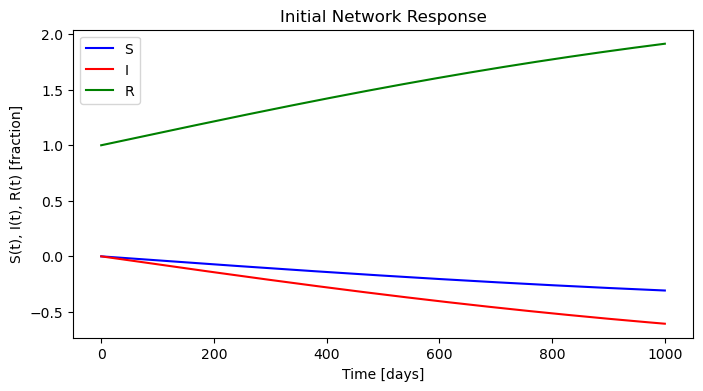

In [37]:
# Prepare t_num for network
t_num = t_num.view(-1,1).double()
t_rescaled = t_num / 1000.0
# Testing network
S, I, R = net(t_rescaled)
fig, ax = plot_solution(t_num, S, I, R, title='Initial Network Response')

In [38]:
# Testing ODE loss
t_num = t_num.clone().requires_grad_()
loss, _, _, _, _, _, _, _, _, _ = get_loss_ode(t_num, net, beta_SIR, alpha_SIR)
print(loss)

tensor(0.0002, dtype=torch.float64, grad_fn=<AddBackward0>)


In [39]:
# Testing IC loss
loss = get_loss_initial_condition(t_num[0], net, S_data[0], I_data[0], R_data[0])
print(loss)
# Testing smoothing
#plt.figure()
xlin = torch.linspace(0, 1.0, 1000)
#plt.plot(xlin, smooth_thresholding(xlin, torch.tensor(0.01), torch.tensor(50.0)))

tensor(1.8899, dtype=torch.float64, grad_fn=<AddBackward0>)


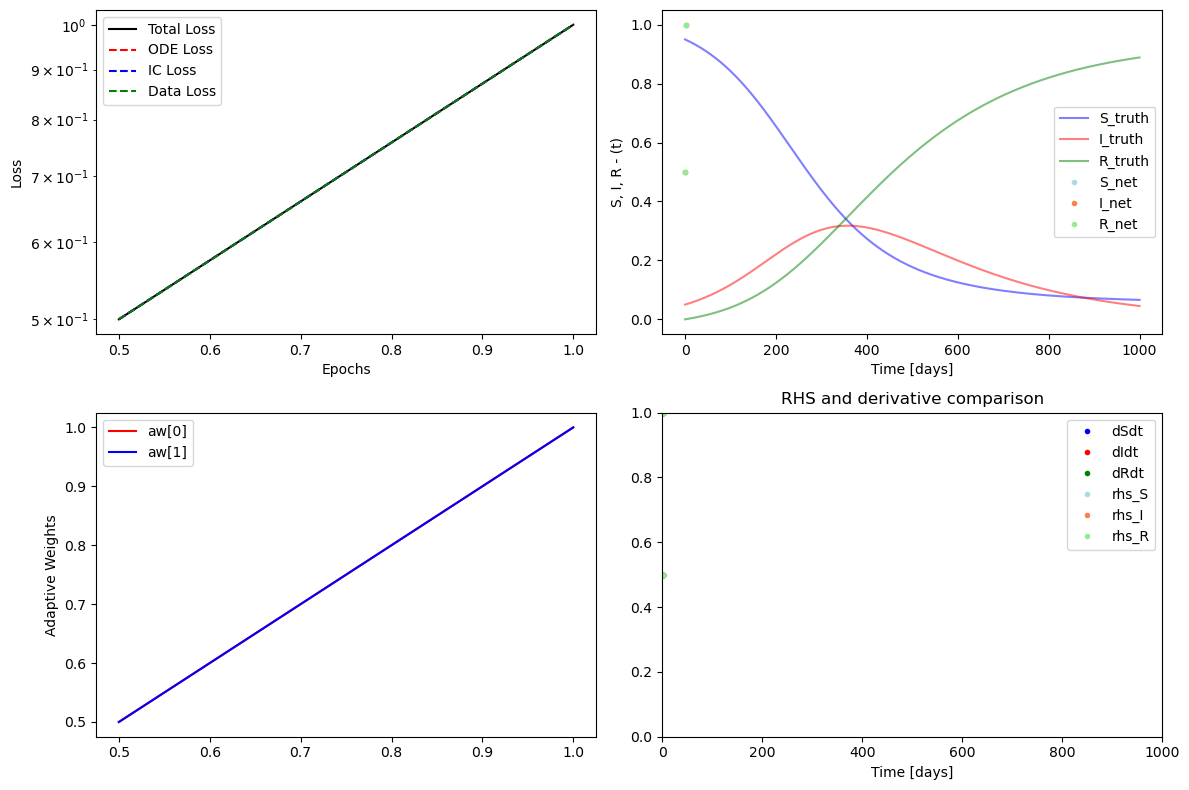

In [54]:
# SoftAdapt setup
softadapt_obj  = LossWeightedSoftAdapt(beta=0.1) # Using loss weighted soft adapt as it is the recommended one.
epochs_to_make_change = 5
adapt_weights = torch.tensor([0.25, 0.25, 0.25, 0.25])    # Initial weighting of objects.

# Setup optimizer
# If we are to estimate beta and alpha
beta_trainable = torch.tensor(beta_SIR * 3.0, device=my_device, dtype=torch.float64, requires_grad=True)
alpha_trainable = torch.tensor(alpha_SIR * 0.3, device=my_device, dtype=torch.float64, requires_grad=True)

learning_rate = 3e-4
#optimizer = optim.Adam(list(net.parameters()) + [beta_trainable, alpha_trainable], lr=learning_rate, weight_decay=1e-6)
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-6)
#optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5)

# Setup training scheduler as in the DINN paper
#base_lr = 1e-5
#max_lr = 1e-3   # Set your maximum learning rate
#gamma_lr = 0.85
#step_size_up = 1000  # Set the number of iterations for the learning rate to go from base_lr to max_lr
#scheduler = optim.lr_scheduler.CyclicLR(optimizer, 
#                                        base_lr=base_lr, 
#                                        max_lr=max_lr, 
#                                        step_size_up=step_size_up, 
#                                        mode='exp_range',
#                                        cycle_momentum=False)

epochs_saved = []
loss_saved = []
loss_ode_saved = []
loss_ic_saved = []
loss_data_saved = []
loss_people_count_saved = []
aw_saved = []

# Create plot
fig, ax, line_loss_total, line_loss_ode, line_loss_ic, line_loss_data, line_S, line_I, line_R, line_RHS_S, line_RHS_I, line_RHS_R, line_dSdt, line_dIdt, line_dRdt, line_aw0, line_aw1 = monitor_plot()

In [59]:
num_epochs = 10000
save_every = 100
loss1, loss2, loss3, loss4 = [], [], [], []

# Move to device
net = net.to(my_device)
t_num_cuda = t_data_points.clone().to(my_device).type(torch.float64)
S_data_cuda = S_data_points.to(my_device).type(torch.float64)
S0 = torch.tensor(S0_num, device=my_device, dtype=torch.float64)
I_data_cuda = I_data_points.to(my_device).type(torch.float64)
I0 = torch.tensor(I0_num, device=my_device, dtype=torch.float64)
R_data_cuda = R_data_points.to(my_device).type(torch.float64)
R0 = torch.tensor(R0_num, device=my_device, dtype=torch.float64)

for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()

    # Get network response
    t_train = torch.linspace(0, 1000, 250, device=my_device, requires_grad=True, dtype=torch.float64).unsqueeze(1)
    #t_train = torch.rand(400, 1, device=my_device, dtype=torch.float64) * 1000.0
    t_train = t_train / 1000.0
    t_train = t_train.requires_grad_()
    
    # Loss
    loss_ode, S, I, R, dSdt, dIdt, dRdt, rhs_S, rhs_I, rhs_R = get_loss_ode(t_train, net, beta_SIR, alpha_SIR)
    loss_ic = get_loss_initial_condition(t_train[0], net, S0, I0, R0)
    loss_data = get_loss_data(t_num_cuda, net, S_data_cuda, I_data_cuda, R_data_cuda)
    loss_people_count, _ = get_loss_for_not_correct_number_of_people(t_train, net)
    
    t_train = t_train * 1000.0
    
    loss1.append( loss_ode )
    loss2.append( loss_ic )
    loss3.append( loss_data )
    loss4.append( loss_people_count )
    
    # Using the softadapt package.
    if epoch % epochs_to_make_change == 0 and epoch != 0:
        adapt_weights = softadapt_obj.get_component_weights(torch.tensor(loss1),
                                                            torch.tensor(loss2),
                                                            torch.tensor(loss3),
                                                            torch.tensor(loss4),
                                                            verbose=False)
        loss1, loss2, loss3, loss4 = [], [], [], []

    #loss = loss_data
    #loss = loss_data + loss_ode + loss_ic
    loss = adapt_weights[0]*loss_ode + adapt_weights[1]*loss_ic + adapt_weights[2]*loss_data + adapt_weights[3]*loss_people_count
    
    loss.backward()
    optimizer.step()
    #scheduler.step()

    if len(epochs_saved) > 0:
        epochs_saved.append( epoch+epochs_saved[-1] )
    else:
        epochs_saved.append(epoch)
    loss_saved.append( loss.to('cpu').detach() )
    loss_ode_saved.append( loss_ode.to('cpu').detach() )
    loss_ic_saved.append( loss_ic.to('cpu').detach() )
    loss_data_saved.append( loss_data.to('cpu').detach() )
    loss_people_count_saved.append( loss_people_count.to('cpu').detach() )
    aw_saved.append([adapt_weights[0], adapt_weights[1]])
    
    if False:  # Make plot that shows loss, solution, adaptive weights, residuals
        if (epoch+1) % save_every == 0 or epoch == 0:
            # Change plot [0]
            line_loss_total.set_data(epochs_saved, loss_saved)
            line_loss_ode.set_data(epochs_saved, loss_ode_saved)
            line_loss_ic.set_data(epochs_saved, loss_ic_saved)
            line_loss_data.set_data(epochs_saved, loss_data_saved)
            ax[0,0].set_xlim(0, max(epochs_saved) + 100)
            max_val = max([max(loss_saved), max(loss_ode_saved), max(loss_ic_saved)])
            ax[0,0].set_ylim(1e-10, max_val*2)

            line_S.set_data(t_train[::20].to('cpu').detach(), S[::20].to('cpu').detach())
            line_I.set_data(t_train[::20].to('cpu').detach(), I[::20].to('cpu').detach())
            line_R.set_data(t_train[::20].to('cpu').detach(), R[::20].to('cpu').detach())

            line_aw0.set_data(epochs_saved, np.transpose(aw_saved)[0,:])
            line_aw1.set_data(epochs_saved, np.transpose(aw_saved)[1,:])
            ax[1,0].set_xlim(0, max(epochs_saved) + 100)
            max_val = max([max(loss_saved), max(loss_ode_saved), max(loss_ic_saved)])
            ax[1,0].set_ylim(-0.1, 1.1)           
           
            line_dSdt.set_data(t_train[::1].to('cpu').detach(), dSdt[::1].to('cpu').detach())
            line_dIdt.set_data(t_train[::1].to('cpu').detach(), dIdt[::1].to('cpu').detach())
            line_dRdt.set_data(t_train[::1].to('cpu').detach(), dRdt[::1].to('cpu').detach())
            line_RHS_S.set_data(t_train[::1].to('cpu').detach(), rhs_S[::1].to('cpu').detach())
            line_RHS_I.set_data(t_train[::1].to('cpu').detach(), rhs_I[::1].to('cpu').detach())
            line_RHS_R.set_data(t_train[::1].to('cpu').detach(), rhs_R[::1].to('cpu').detach())
            min_val = min(min(rhs_S), min(rhs_I), min(rhs_R), min(dSdt), min(dIdt), min(dRdt))
            max_val = max(max(rhs_S), max(rhs_I), max(rhs_R), max(dSdt), max(dIdt), max(dRdt))
            ax[1,1].set_ylim(min_val.to('cpu').detach(), max_val.to('cpu').detach())
            
            display(fig)
            clear_output(wait = True)
    else:
        if (epoch+1) % save_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1:5}, Loss: {loss.item():10.5E}, ode_loss: {loss_ode:10.5E}, ic_loss: {loss_ic:10.5E}"
                  f", data_loss: {loss_data:10.5E}, count_loss: {loss_people_count:10.5E}"
                  f"\n             aw[0]: {adapt_weights[0]:3.6f}, aw[1]: {adapt_weights[1]:3.6f},"
                  f" aw[2]: {adapt_weights[2]:3.6f}, aw[3]: {adapt_weights[3]:3.6f},")
    
    
    

Epoch     1, Loss: 1.70556E-06, ode_loss: 2.01934E-06, ic_loss: 1.20767E-11, data_loss: 5.25666E-07, count_loss: 4.28823E-11
             aw[0]: 0.791302, aw[1]: 0.000005, aw[2]: 0.204782, aw[3]: 0.000017,
Epoch   100, Loss: 1.54359E-06, ode_loss: 1.83991E-06, ic_loss: 9.19205E-12, data_loss: 5.20400E-07, count_loss: 3.57583E-11
             aw[0]: 0.777094, aw[1]: 0.000004, aw[2]: 0.218688, aw[3]: 0.000015,
Epoch   200, Loss: 1.39067E-06, ode_loss: 1.66764E-06, ic_loss: 6.69037E-12, data_loss: 5.13072E-07, count_loss: 2.79288E-11
             aw[0]: 0.762136, aw[1]: 0.000003, aw[2]: 0.233305, aw[3]: 0.000013,
Epoch   300, Loss: 1.24903E-06, ode_loss: 1.50545E-06, ic_loss: 4.63538E-12, data_loss: 5.03859E-07, count_loss: 2.00975E-11
             aw[0]: 0.746477, aw[1]: 0.000002, aw[2]: 0.248583, aw[3]: 0.000010,
Epoch   400, Loss: 1.11918E-06, ode_loss: 1.35423E-06, ic_loss: 3.04743E-12, data_loss: 4.93276E-07, count_loss: 1.29413E-11
             aw[0]: 0.730060, aw[1]: 0.000002, aw[2

Epoch  4000, Loss: 3.55307E-07, ode_loss: 3.63158E-07, ic_loss: 6.69010E-13, data_loss: 3.57262E-07, count_loss: 0.00000E+00
             aw[0]: 0.497366, aw[1]: 0.000001, aw[2]: 0.488956, aw[3]: 0.000000,
Epoch  4100, Loss: 3.49655E-07, ode_loss: 3.55525E-07, ic_loss: 6.76754E-13, data_loss: 3.53631E-07, count_loss: 0.00000E+00
             aw[0]: 0.494528, aw[1]: 0.000001, aw[2]: 0.491579, aw[3]: 0.000000,
Epoch  4200, Loss: 3.44253E-07, ode_loss: 3.48331E-07, ic_loss: 6.83539E-13, data_loss: 3.50023E-07, count_loss: 0.00000E+00
             aw[0]: 0.491898, aw[1]: 0.000001, aw[2]: 0.493997, aw[3]: 0.000000,
Epoch  4300, Loss: 3.39096E-07, ode_loss: 3.41557E-07, ic_loss: 6.89430E-13, data_loss: 3.46450E-07, count_loss: 0.00000E+00
             aw[0]: 0.489471, aw[1]: 0.000001, aw[2]: 0.496214, aw[3]: 0.000000,
Epoch  4400, Loss: 3.34172E-07, ode_loss: 3.35187E-07, ic_loss: 6.94496E-13, data_loss: 3.42920E-07, count_loss: 0.00000E+00
             aw[0]: 0.487241, aw[1]: 0.000001, aw[2

Epoch  8000, Loss: 2.74337E-07, ode_loss: 2.60357E-07, ic_loss: 7.32921E-13, data_loss: 2.95907E-07, count_loss: 0.00000E+00
             aw[0]: 0.459785, aw[1]: 0.000001, aw[2]: 0.522558, aw[3]: 0.000000,
Epoch  8100, Loss: 2.73121E-07, ode_loss: 2.59195E-07, ic_loss: 7.29334E-13, data_loss: 2.94640E-07, count_loss: 0.00000E+00
             aw[0]: 0.459704, aw[1]: 0.000001, aw[2]: 0.522564, aw[3]: 0.000000,
Epoch  8200, Loss: 2.71934E-07, ode_loss: 2.58083E-07, ic_loss: 7.25560E-13, data_loss: 2.93386E-07, count_loss: 0.00000E+00
             aw[0]: 0.459658, aw[1]: 0.000001, aw[2]: 0.522535, aw[3]: 0.000000,
Epoch  8300, Loss: 2.70777E-07, ode_loss: 2.57019E-07, ic_loss: 7.21636E-13, data_loss: 2.92147E-07, count_loss: 0.00000E+00
             aw[0]: 0.459646, aw[1]: 0.000001, aw[2]: 0.522473, aw[3]: 0.000000,
Epoch  8400, Loss: 1.38547E-04, ode_loss: 2.54435E-07, ic_loss: 5.04944E-07, data_loss: 1.40330E-04, count_loss: 0.00000E+00
             aw[0]: 0.000748, aw[1]: 0.007766, aw[2

In [56]:
print(f'Beta found in network  {beta_trainable:6.5f} vs real beta  {beta_SIR:6.5f}')
print(f'alpha found in network {alpha_trainable:6.5f} vs real alpha {alpha_SIR:6.5f}')


Beta found in network  0.04500 vs real beta  0.01500
alpha found in network 0.00150 vs real alpha 0.00500


Text(0, 0.5, 'R(t)')

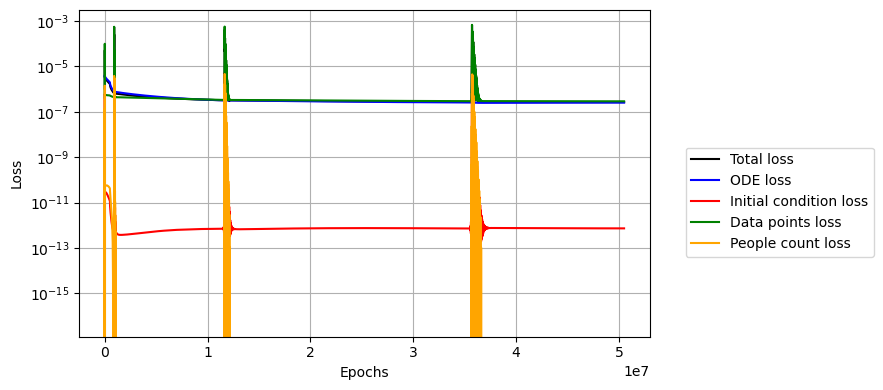

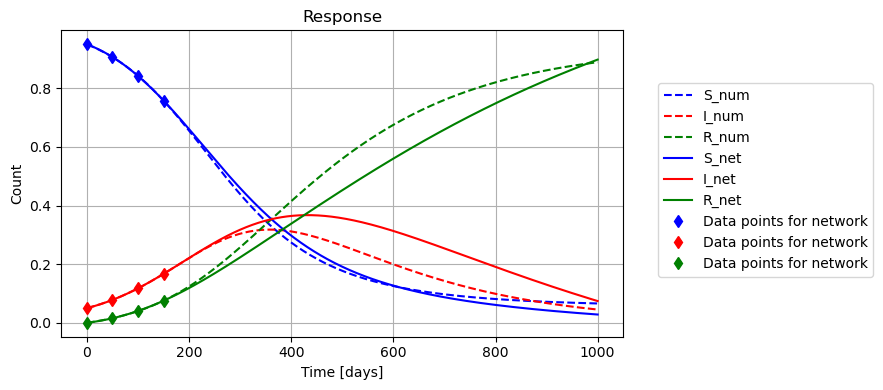

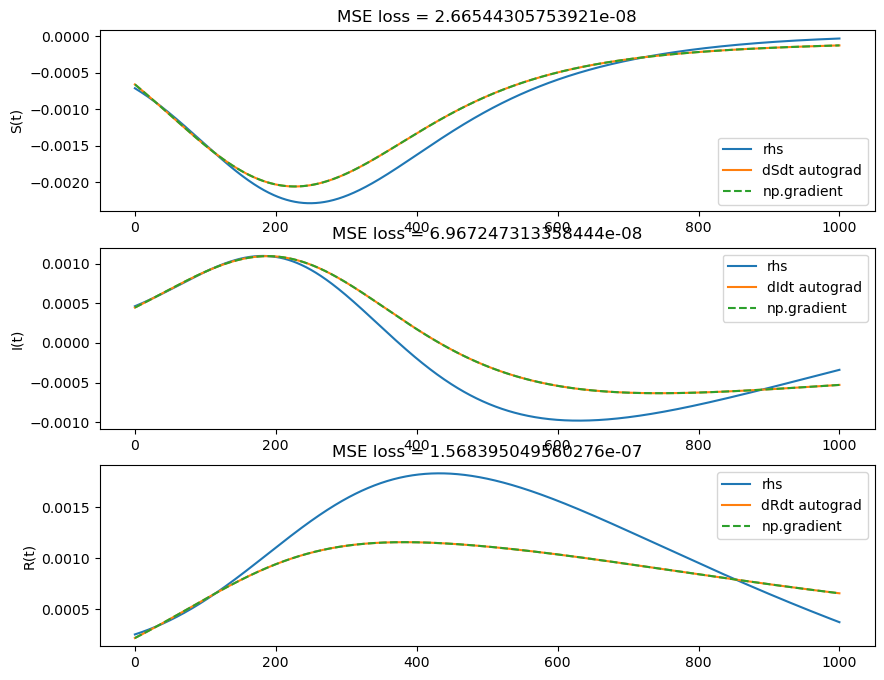

In [60]:
# Plot loss
fig, ax = plt.subplots(1, 1, figsize=(9,4))
ax.plot(epochs_saved, loss_saved, color='k', label='Total loss')
ax.plot(epochs_saved, loss_ode_saved, color='blue', label='ODE loss')
ax.plot(epochs_saved, loss_ic_saved, color='red', label='Initial condition loss')
ax.plot(epochs_saved, loss_data_saved, color='green', label='Data points loss')
ax.plot(epochs_saved, loss_people_count_saved, color='orange', label='People count loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 0.6))
fig.tight_layout()

# Prepare t_num for network
net_cpu = net.to('cpu').eval()
t_num = t_num.view(-1,1).double() / 1000.0
# How the fuck does this give a low loss
loss_ode, S, I, R, dSdt, dIdt, dRdt, rhs_S, rhs_I, rhs_R = get_loss_ode(t_num.requires_grad_(), net, beta_SIR, alpha_SIR)
t_num = t_num * 1000.0

fig, ax = plt.subplots(1, 1, figsize=(9,4))
ax.plot(t_num.to('cpu').detach(), S_data.to('cpu').detach(), color='blue', linestyle='--', label='S_num')
ax.plot(t_num.to('cpu').detach(), I_data.to('cpu').detach(), color='red', linestyle='--', label='I_num')
ax.plot(t_num.to('cpu').detach(), R_data.to('cpu').detach(), color='green', linestyle='--', label='R_num')
ax.plot(t_num.to('cpu').detach(), S.to('cpu').detach(), color='blue', label='S_net')
ax.plot(t_num.to('cpu').detach(), I.to('cpu').detach(), color='red', label='I_net')
ax.plot(t_num.to('cpu').detach(), R.to('cpu').detach(), color='green', label='R_net')
ax.plot(t_data_points, S_data_points, linestyle='', marker='d', color='blue', label='Data points for network')
ax.plot(t_data_points, I_data_points, linestyle='', marker='d', color='red', label='Data points for network')
ax.plot(t_data_points, R_data_points, linestyle='', marker='d', color='green', label='Data points for network')
ax.set_xlabel('Time [days]')
ax.set_ylabel('Count')
ax.set_title('Response')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 0.85))
fig.tight_layout()

#    dSdt = -beta_SIR * S * I
#    dIdt = beta_SIR * S * I - alpha_SIR * I
#    dRdt = alpha_SIR * I

fig, ax = plt.subplots(3, 1, figsize=(10,8))
ax[0].plot(t_num.detach(), -beta_SIR * S.detach() * I.detach())
ax[0].plot(t_num.detach(), dSdt.detach())
ax[0].plot(t_num.detach(), np.gradient(S.detach().numpy().reshape(-1), 1), linestyle='--')
ax[0].legend(['rhs', 'dSdt autograd', 'np.gradient'])
ax[0].set_title(f'MSE loss = {torch_MSE_loss(-beta_SIR * S.detach() * I.detach(), dSdt.detach())}')
ax[0].set_ylabel('S(t)')
ax[1].plot(t_num.detach(), beta_SIR * S.detach() * I.detach() - alpha_SIR * I.detach())
ax[1].plot(t_num.detach(), dIdt.detach())
ax[1].plot(t_num.detach(), np.gradient(I.detach().numpy().reshape(-1), 1), linestyle='--')
ax[1].legend(['rhs', 'dIdt autograd', 'np.gradient'])
ax[1].set_title(f'MSE loss = {torch_MSE_loss(beta_SIR * S.detach() * I.detach() - alpha_SIR * I.detach(), dIdt.detach())}')
ax[1].set_ylabel('I(t)')
ax[2].plot(t_num.detach(), alpha_SIR * I.detach())
ax[2].plot(t_num.detach(), dRdt.detach())
ax[2].plot(t_num.detach(), np.gradient(R.detach().numpy().reshape(-1), 1), linestyle='--')
ax[2].legend(['rhs', 'dRdt autograd', 'np.gradient'])
ax[2].set_title(f'MSE loss = {torch_MSE_loss(alpha_SIR * I.detach(), dRdt.detach())}')
ax[2].set_ylabel('R(t)')

The solver successfully reached the end of the integration interval.
tensor(8.0449e-12, dtype=torch.float64)
tensor(9.0896e-12, dtype=torch.float64)
tensor(1.2352e-12, dtype=torch.float64)


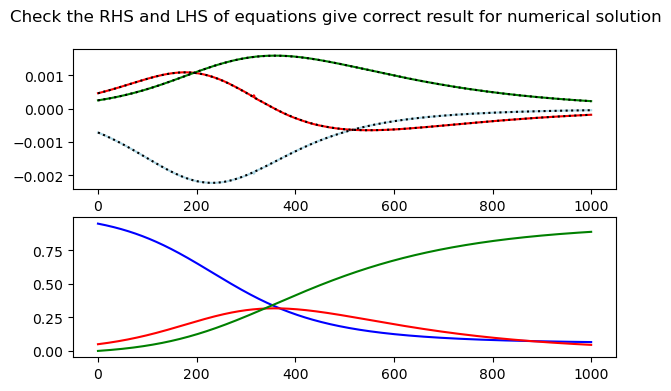

In [108]:
n_points = 1001

t_num = torch.linspace(0, n_days, n_points)

sol = solve_ivp(SIR_model_num, [t_num[0], t_num[-1]], y0, args=(beta_SIR, alpha_SIR), t_eval=t_num, method='LSODA')

S_data = torch.tensor(sol.y[0])
I_data = torch.tensor(sol.y[1])
R_data = torch.tensor(sol.y[2])
print(sol.message)

# Testing whether my brain is broken
dSdt_data = np.gradient(S_data, n_days/n_points)
dIdt_data = np.gradient(I_data, n_days/n_points)
dRdt_data = np.gradient(R_data, n_days/n_points)
rhs_S_data = -beta_SIR * S_data * I_data
rhs_I_data = beta_SIR * S_data * I_data - alpha_SIR * I_data
rhs_R_data = alpha_SIR * I_data

fig, ax = plt.subplots(2, 1, figsize=(7,4))
fig.suptitle('Check the RHS and LHS of equations give correct result for numerical solution')
ax[0].plot(t_num.detach(), dSdt_data, color='lightblue', linestyle='-', alpha=1)
ax[0].plot(t_num.detach(), dIdt_data, color='red', linestyle='-', alpha=1)
ax[0].plot(t_num.detach(), dRdt_data, color='green', linestyle='-', alpha=1)
ax[0].plot(t_num.detach(), rhs_S_data, color='k', linestyle=':')
ax[0].plot(t_num.detach(), rhs_I_data, color='k', linestyle=':')
ax[0].plot(t_num.detach(), rhs_R_data, color='k', linestyle=':')

ax[1].plot(t_num.detach(), S_data, color='blue')
ax[1].plot(t_num.detach(), I_data, color='red')
ax[1].plot(t_num.detach(), R_data, color='green')

# Print the residual
print(torch_MSE_loss(rhs_S_data.clone().detach(), torch.tensor(dSdt_data)))
print(torch_MSE_loss(rhs_I_data.clone().detach(), torch.tensor(dIdt_data)))
print(torch_MSE_loss(rhs_R_data.clone().detach(), torch.tensor(dRdt_data)))

tensor(1.4649e-08, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.4411e-08, dtype=torch.float64, grad_fn=<MseLossBackward0>)


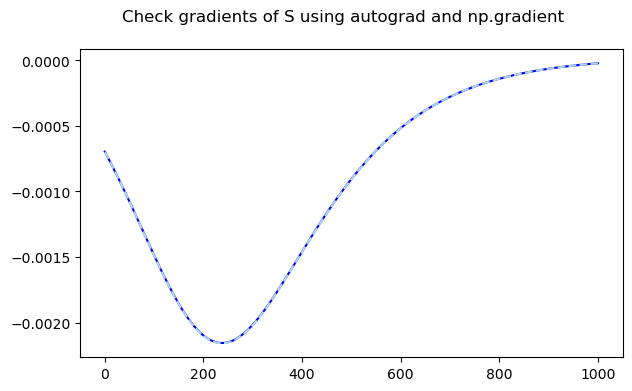

In [109]:
# Check that numpy.gradient gives same result as network through autograd
t = torch.linspace(0, n_days, n_points, requires_grad=True, dtype=torch.double).view(-1,1)
t = t / 1000.0
S_net, I_net, R_net = net_cpu(t)
dSdt_autograd =  1/1000*torch.autograd.grad(S_net, t, grad_outputs=torch.ones_like(S_net), create_graph=True)[0]

t = t*1000.0
dSdt_npgrad = np.gradient(S_net.detach().reshape(-1), n_days/n_points)

fig, ax = plt.subplots(1, 1, figsize=(7,4))
fig.suptitle('Check gradients of S using autograd and np.gradient')
ax.plot(t.detach(), dSdt_autograd.detach(), color='blue')
ax.plot(t.detach(), dSdt_npgrad, color='lightblue', linestyle='--')

print(torch_MSE_loss(dSdt_autograd, -beta_SIR * S_net * I_net))
print(torch_MSE_loss(torch.tensor(dSdt_npgrad).view(-1,1), -beta_SIR * S_net * I_net))